## Загрузка исторических данных (pre-experiment baseline)

In [ ]:
# Подключение стандартных библиотек для анализа
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
DATA_PATH = (
    "https://raw.githubusercontent.com/"
    "SVNasonkova/portfolio_ab_testing/"
    "4ef31e800636074cceda6f0bc5d7027ed1f05037/"
    "case_3_edtech-ab-test/data/edtech_events.csv"
)

df = pd.read_csv(DATA_PATH)
df.head()

,dt,client_id,event_type,course_id,price
0,2025-04-29 20:15:39,4543,view_carousel,358,NaN
1,2025-04-18 13:22:37,4101,enroll,158,NaN
2,2025-04-25 17:32:37,4666,enroll,382,NaN
3,2025-04-21 21:42:16,4220,view_carousel,554,NaN
4,2025-04-07 15:01:53,4347,enroll,304,NaN


Файл edtech_events.csv — это исторический лог пользовательских событий в продукте EdTech. Он содержит события просмотра карусели, кликов по курсам, записей и оплат. Эти данные используются как baseline до эксперимента для анализа воронки, расчёта базовых метрик и оценки минимального детектируемого эффекта. Разделения на A/B-группы в файле нет.

## Проверка качества данных

### Проверка типов данных

In [ ]:
print("Текущие типы данных:")
df.info()

Текущие типы данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dt          100 non-null    object 
 1   client_id   100 non-null    int64  
 2   event_type  100 non-null    object 
 3   course_id   100 non-null    int64  
 4   price       9 non-null      float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ KB


dt — строка (требует преобразования в datetime)


In [ ]:
# Приведение столбца 'dt' к формату даты
df['dt'] = pd.to_datetime(df['dt'])
print("\nТипы данных после конвертации 'dt' в формат даты:")
df.info()


Типы данных после конвертации 'dt' в формат даты:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   dt          100 non-null    datetime64[ns]
 1   client_id   100 non-null    int64         
 2   event_type  100 non-null    object        
 3   course_id   100 non-null    int64         
 4   price       9 non-null      float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 4.0+ KB


### Проверка на пропуски данных и на наличие дубликатов


In [ ]:
missing_values = df.isnull().sum()
print("Количество пропущенных значений в каждом столбце:")
print(missing_values)

Количество пропущенных значений в каждом столбце:
dt             0
client_id      0
event_type     0
course_id      0
price         91
dtype: int64


In [ ]:
print("Проверка на дубликаты:")
duplicate_rows = df[df.duplicated(keep=False)]

if not duplicate_rows.empty:
    print(f"Обнаружено {len(duplicate_rows)} дублированных строк.\n")
    print("Дублированные строки:")
    print(duplicate_rows)
else:
    print("Дубликатов не обнаружено.")

Проверка на дубликаты:
Дубликатов не обнаружено.


Обнаружены пропуски только в столбце "price" (91 из 100 записей). Это является ожидаемым, так как цена логируется только для событий `pay`. В остальных столбцах пропуски отсутствуют, что указывает на полноту данных для основных полей.

Вывод: пропуски в price корректны и не требуют дополнительной очистки.


Проверка показала полное отсутствие дубликатов в датафрейме, что обеспечивает уникальность каждой записи и предотвращает возможное искажение статистики.

Вывод: дубликаты не обнаружены.

### Анализ выбросов в price

Исследовать столбец "price" на предмет аномально высоких или низких значений, ошибок логирования, которые могут влиять на анализ.


In [ ]:
print("Описательная статистика для столбца price:")
print(df["price"].describe())

Описательная статистика для столбца price:
count        9.000000
mean     13323.333333
std       6614.378278
min       4990.000000
25%       9990.000000
50%       9990.000000
75%      19990.000000
max      19990.000000
Name: price, dtype: float64


Отрицательных и нулевых значений в столбце "price" не обнаружено

In [ ]:
## Расчет Q1 и Q3 для нахождения межквартильного диапазона (IQR)
Q1 = df["price"].quantile(0.25)
Q3 = df["price"].quantile(0.75)
print(f"Первый квартиль (Q1) для столбца price: {Q1}")
print(f"Третий квартиль (Q3) для столбца price: {Q3}")

Первый квартиль (Q1) для столбца price: 9990.0
Третий квартиль (Q3) для столбца price: 19990.0


In [ ]:
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df["price"] < lower_bound) | (df["price"] > upper_bound)]["price"]

print(f"Межквартильный диапазон (IQR) для столбца price: {IQR}")
print(f"Нижняя граница для выбросов: {lower_bound}")
print(f"Верхняя граница для выбросов: {upper_bound}")
print("Выбросы в столбце price:")
print(outliers)

Межквартильный диапазон (IQR) для столбца price: 10000.0
Нижняя граница для выбросов: -5010.0
Верхняя граница для выбросов: 34990.0
Выбросы в столбце price:
Series([], Name: price, dtype: float64)


Выбросов в столбце "price" по методу IQR не обнаружено.

Вывод:

Денежные данные были проверены на наличие технических выбросов (нулевые, отрицательные и аномально большие значения). Таких значений обнаружено не было.

### Проверка корректности событий

In [ ]:
event_counts = df['event_type'].value_counts()
print("Распределение типов событий:")
print(event_counts)

Распределение типов событий:
event_type
view_carousel    47
click_course     28
enroll           16
pay               9
Name: count, dtype: int64


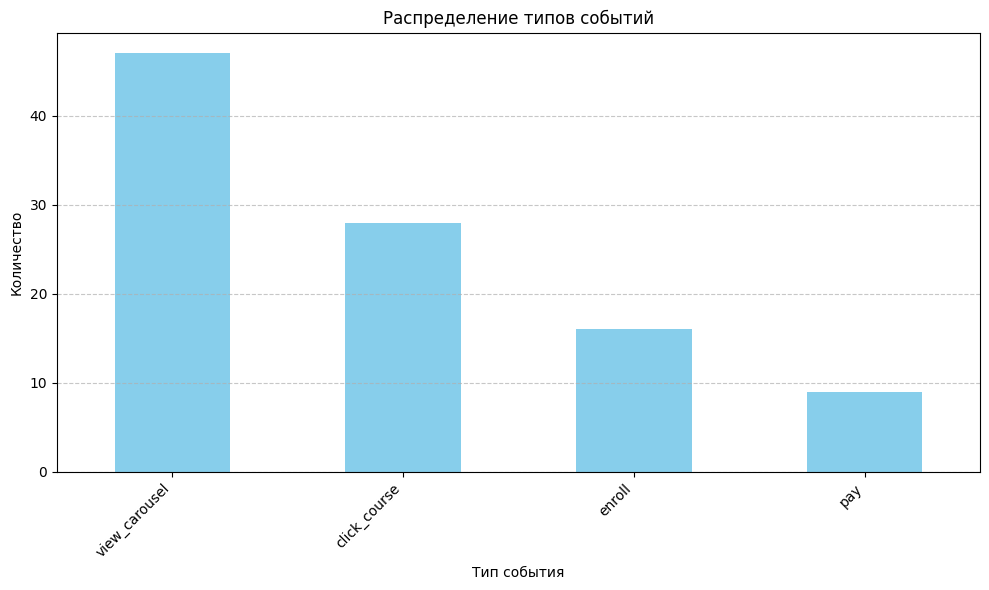

In [ ]:
plt.figure(figsize=(10, 6))
event_counts.plot(kind='bar', color='skyblue')
plt.title('Распределение типов событий')
plt.xlabel('Тип события')
plt.ylabel('Количество')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Наблюдения:

Чётко прослеживается воронка: view → click → enroll → pay

На каждом этапе происходит ожидаемое снижение количества событий.

Вывод:
Логирование последовательности событий выглядит консистентным и соответствует бизнес-логике продукта.

In [ ]:
# Описательная статистика
# Уникальные пользователи и даты
unique_users = df["client_id"].nunique()
date_range = df["dt"].agg(["min", "max"])

# События для каждого пользователя
events_per_user = df.groupby("client_id").size().describe()

print(f"\nКоличество уникальных пользователей: {unique_users}")
print(f"Диапазон дат: от {date_range['min']} до {date_range['max']}")
print("\nОписательная статистика по количеству событий на пользователя:")
print(events_per_user)


Количество уникальных пользователей: 96
Диапазон дат: от 2025-04-01 20:09:05 до 2025-04-29 20:15:39

Описательная статистика по количеству событий на пользователя:
count    96.000000
mean      1.041667
std       0.200875
min       1.000000
25%       1.000000
50%       1.000000
75%       1.000000
max       2.000000
dtype: float64


**Общая характеристика данных**

Объём и структура:

Количество строк: 100 событий

Количество пользователей (client_id): 96

Период данных: 01.04.2025 – 29.04.2025

Среднее число событий на пользователя: ~1.04

Максимум событий на пользователя: 2

Вывод:

Данные представляют собой лог событий с крайне низкой интенсивностью взаимодействий: большинство пользователей за рассматриваемый период совершили одно действие. В дальнейшем анализе единицей наблюдения выбран пользователь (user-level), что позволяет корректно учитывать нулевые значения метрик и избежать искажения дисперсий. Агрегация по дням используется исключительно для описательного анализа и визуализации динамики.

## Расчет воронки событий на уровне пользователя и по дням


In [ ]:
# Извлечение календарной даты
df["date"] = df["dt"].dt.date

# Создание ежедневной воронки на уровне пользователей
funnel_user_day = (
    df.assign(
        views=(df["event_type"] == "view_carousel").astype(int),
        clicks=(df["event_type"] == "click_course").astype(int),
        enrolls=(df["event_type"] == "enroll").astype(int),
        pays=(df["event_type"] == "pay").astype(int),
        revenue=df["price"].fillna(0)
    )
    .groupby(["date", "client_id"], as_index=False)
    .agg({
        "views": "sum",
        "clicks": "sum",
        "enrolls": "sum",
        "pays": "sum",
        "revenue": "sum"
    })
)
funnel_user_day.head()

,date,client_id,views,clicks,enrolls,pays,revenue
0,2025-04-01,4279,0,1,0,0,0.0
1,2025-04-02,4209,1,0,0,0,0.0
2,2025-04-02,4294,0,1,0,0,0.0
3,2025-04-02,4373,0,1,0,0,0.0
4,2025-04-02,4452,0,1,0,0,0.0


Воронка собрана на уровне:
dt + client_id (пользователь в конкретный день)

Все количественные оценки метрик и дисперсий в дальнейшем рассчитываются на уровне пользователя (user-level)

In [ ]:
funnel_user = (
    funnel_user_day
    .groupby("client_id", as_index=False)
    .agg({
        "views": "sum",
        "clicks": "sum",
        "enrolls": "sum",
        "pays": "sum",
        "revenue": "sum"
    })
)
funnel_user.head()

,client_id,views,clicks,enrolls,pays,revenue
0,4018,1,0,0,0,0.0
1,4053,0,0,1,0,0.0
2,4057,1,0,0,0,0.0
3,4077,1,0,0,0,0.0
4,4078,0,1,0,0,0.0


In [ ]:
total_views = funnel_user["views"].sum()
total_clicks = funnel_user["clicks"].sum()
total_enrolls = funnel_user["enrolls"].sum()
total_pays = funnel_user["pays"].sum()
total_revenue = funnel_user["revenue"].sum()
unique_users = funnel_user.shape[0]

Базовые метрики рассчитываются на уровне пользователя (per user),
так как именно на этом уровне предполагается рандомизация в A/B-тесте.
Агрегация user-day используется исключительно для анализа динамики
и визуализации поведения пользователей во времени.


In [ ]:
baseline_metrics = pd.DataFrame({
    "metric": ["CTR", "CR_enroll", "AOV", "ARPU"],
    "value": [
        total_clicks / total_views if total_views > 0 else np.nan,
        total_enrolls / total_clicks if total_clicks > 0 else np.nan,
        total_revenue / total_pays if total_pays > 0 else np.nan,
        total_revenue / unique_users
    ]
})

funnel_user.head(), baseline_metrics

(   client_id  views  clicks  enrolls  pays  revenue
 0       4018      1       0        0     0      0.0
 1       4053      0       0        1     0      0.0
 2       4057      1       0        0     0      0.0
 3       4077      1       0        0     0      0.0
 4       4078      0       1        0     0      0.0,
       metric         value
 0        CTR      0.595745
 1  CR_enroll      0.571429
 2        AOV  13323.333333
 3       ARPU   1249.062500)

Ключевые выводы baseline-анализа

 - CR_enroll уже очень высокий (~57%)
относительный рост в 2.5% будет трудно поймать,
потребуется аккуратный расчёт MDE.

 - Данные разреженные большинство пользователей имеют 1 событие, рекомендуется bootstrap вместо чистого t-test.

- Денежные метрики шумные AOV и ARPU, их нужно использовать как secondary, фокус — на CR_enroll.

**Guardrail-метрики**

Помимо ключевых и вспомогательных метрик, в эксперименте фиксируются guardrail-метрики,  
цель которых — убедиться, что персонализация не ухудшает пользовательский опыт и не приводит к деградации воронки.

В рамках анализа следует рассмотреть:
- долю пользователей, не совершивших ни одного клика по карусели;
- сквозную конверсию от просмотра карусели до записи на курс (view → enroll);
- распределение времени до первого клика (если данные доступны).

Эксперимент считается корректным только при отсутствии негативного эффекта по guardrail-метрикам.


Для оценки дисперсии ratio-метрики CR_enroll может быть использован дельта-метод. Однако с учётом малого числа кликов и значительной доли наблюдений с нулевым знаменателем, оценка дисперсии по дельта-методу является нестабильной. В связи с этим для проверки статистической значимости и доверительных интервалов предпочтительно использовать bootstrap.

In [ ]:
# Создайте копию df, чтобы избежать изменения исходного фрейма данных с помощью столбца "дата", если он уже добавлен
temp_df = df.copy()

# Извлечение календарной даты. Делаем это более надежно, преобразуя в datetime, если dt еще не date-like.
temp_df["date"] = pd.to_datetime(temp_df["dt"]).dt.date

# Создание ежедневной воронки на уровне пользователей
funnel_user = (
    temp_df.assign(
        views=(temp_df["event_type"] == "view_carousel").astype(int),
        clicks=(temp_df["event_type"] == "click_course").astype(int),
        enrolls=(temp_df["event_type"] == "enroll").astype(int),
        pays=(temp_df["event_type"] == "pay").astype(int),
        revenue=temp_df["price"].fillna(0)
    )
    .groupby(["date", "client_id"], as_index=False)
    .agg({
        "views": "sum",
        "clicks": "sum",
        "enrolls": "sum",
        "pays": "sum",
        "revenue": "sum"
    })
)

# Расчет базовых показателей
total_views = funnel_user["views"].sum()
total_clicks = funnel_user["clicks"].sum()
total_enrolls = funnel_user["enrolls"].sum()
total_pays = funnel_user["pays"].sum()
total_revenue = funnel_user["revenue"].sum()
unique_users = funnel_user["client_id"].nunique()

baseline_metrics = pd.DataFrame({
    "metric": ["CTR", "CR_enroll", "AOV", "ARPU"],
    "value": [
        total_clicks / total_views if total_views > 0 else np.nan,
        total_enrolls / total_clicks if total_clicks > 0 else np.nan,
        total_revenue / total_pays if total_pays > 0 else np.nan,
        total_revenue / unique_users
    ]
})

# Количество наблюдений (пар пользователь-день)
N = len(funnel_user)

# Среднее количество enrolls и clicks на пользователя в день
mean_enrolls_per_user = funnel_user['enrolls'].mean()
mean_clicks_per_user = funnel_user['clicks'].mean()

# Дисперсия enrolls и clicks на пользователя в день
var_enrolls_per_user = funnel_user['enrolls'].var(ddof=1) # ddof=1 for sample variance
var_clicks_per_user = funnel_user['clicks'].var(ddof=1)   # ddof=1 for sample variance

# Ковариация между enrolls и clicks на пользователя в день
cov_enrolls_clicks_per_user = funnel_user['enrolls'].cov(funnel_user['clicks'])

# Общий CR_enroll (значение метрики)
cr_enroll_overall = baseline_metrics[baseline_metrics['metric'] == 'CR_enroll']['value'].iloc[0]

# Применение дельта-метода для оценки дисперсии отношения
# Var(R_hat) = (1 / (N * mean_clicks^2)) * (Var(Y_i) + R_hat^2 * Var(X_i) - 2 * R_hat * Cov(X_i, Y_i))

variance_cr_enroll = np.nan
if mean_clicks_per_user > 0:
    term1 = var_enrolls_per_user
    term2 = cr_enroll_overall**2 * var_clicks_per_user
    term3 = 2 * cr_enroll_overall * cov_enrolls_clicks_per_user

    # Важно: Дельта-метод для отношения средних требует деления на N (количество наблюдений)
    variance_cr_enroll = (1 / (N * mean_clicks_per_user**2)) * (term1 + term2 - term3)

print(f"Среднее количество enrolls на пользователя в день: {mean_enrolls_per_user:.4f}")
print(f"Среднее количество clicks на пользователя в день: {mean_clicks_per_user:.4f}")
print(f"Дисперсия enrolls на пользователя в день: {var_enrolls_per_user:.4f}")
print(f"Дисперсия clicks на пользователя в день: {var_clicks_per_user:.4f}")
print(f"Ковариация enrolls и clicks на пользователя в день: {cov_enrolls_clicks_per_user:.4f}")
print(f"Общий CR_enroll: {cr_enroll_overall:.4f}")
print(f"\nРасчетная дисперсия для метрики CR_enroll (дельта-метод): {variance_cr_enroll:.8f}")

# Стандартная ошибка
std_err_cr_enroll = np.sqrt(variance_cr_enroll) if not np.isnan(variance_cr_enroll) else np.nan
print(f"Стандартная ошибка для метрики CR_enroll: {std_err_cr_enroll:.8f}")

Среднее количество enrolls на пользователя в день: 0.1600
Среднее количество clicks на пользователя в день: 0.2800
Дисперсия enrolls на пользователя в день: 0.1358
Дисперсия clicks на пользователя в день: 0.2036
Ковариация enrolls и clicks на пользователя в день: -0.0453
Общий CR_enroll: 0.5714

Расчетная дисперсия для метрики CR_enroll (дельта-метод): 0.03239391
Стандартная ошибка для метрики CR_enroll: 0.17998308


### Проверка логических нарушений воронки

Проверить наличие событий 'pay' без предшествующих 'enroll' и событий 'enroll' без предшествующих 'click_course' для тех же 'client_id' и 'course_id'.


In [ ]:
df_sorted = df.copy().sort_values(by=['client_id', 'course_id', 'dt']).reset_index(drop=True)

# Проверка наличия 'pay' без предварительного 'enroll'
df_sorted['is_enroll'] = (df_sorted['event_type'] == 'enroll').astype(int)
df_sorted['enroll_occurred_before'] = df_sorted.groupby(['client_id', 'course_id'])['is_enroll'].cumsum().shift(1).fillna(0).astype(bool)
pay_without_enroll = df_sorted[(df_sorted['event_type'] == 'pay') & (~df_sorted['enroll_occurred_before'])]

# Check for 'enroll' without preceding 'click_course'
df_sorted['is_click_course'] = (df_sorted['event_type'] == 'click_course').astype(int)
df_sorted['click_course_occurred_before'] = df_sorted.groupby(['client_id', 'course_id'])['is_click_course'].cumsum().shift(1).fillna(0).astype(bool)
enroll_without_click_course = df_sorted[(df_sorted['event_type'] == 'enroll') & (~df_sorted['click_course_occurred_before'])]

print("События 'pay' без предшествующего 'enroll' (для тех же client_id и course_id):")
print(pay_without_enroll)

print("\nСобытия 'enroll' без предшествующего 'click_course' (для тех же client_id и course_id):")
print(enroll_without_click_course)

События 'pay' без предшествующего 'enroll' (для тех же client_id и course_id):
                    dt  client_id event_type  course_id    price        date  \
36 2025-04-20 06:54:54       4383        pay        451  19990.0  2025-04-20   
38 2025-04-11 20:16:37       4395        pay        291   4990.0  2025-04-11   
59 2025-04-17 03:14:02       4600        pay        387   9990.0  2025-04-17   
65 2025-04-17 03:29:27       4623        pay        524   9990.0  2025-04-17   
76 2025-04-17 19:18:35       4697        pay        389   9990.0  2025-04-17   
77 2025-04-04 17:45:01       4725        pay        258  19990.0  2025-04-04   
87 2025-04-23 08:41:02       4828        pay        469  19990.0  2025-04-23   

    is_enroll  enroll_occurred_before  
36          0                   False  
38          0                   False  
59          0                   False  
65          0                   False  
76          0                   False  
77          0                   False  


In [ ]:
df_sorted = df.copy().sort_values(by=['client_id', 'course_id', 'dt']).reset_index(drop=True)

# Проверка наличия 'pay' без предварительного 'enroll'
df_sorted['is_enroll'] = (df_sorted['event_type'] == 'enroll').astype(int)
df_sorted['enroll_occurred_before'] = df_sorted.groupby(['client_id', 'course_id'])['is_enroll'].cumsum().shift(1).fillna(0).astype(bool)
pay_without_enroll = df_sorted[(df_sorted['event_type'] == 'pay') & (~df_sorted['enroll_occurred_before'])]

# Check for 'enroll' without preceding 'click_course'
df_sorted['is_click_course'] = (df_sorted['event_type'] == 'click_course').astype(int)
df_sorted['click_course_occurred_before'] = df_sorted.groupby(['client_id', 'course_id'])['is_click_course'].cumsum().shift(1).fillna(0).astype(bool)
enroll_without_click_course = df_sorted[(df_sorted['event_type'] == 'enroll') & (~df_sorted['click_course_occurred_before'])]

print("События 'pay' без предшествующего 'enroll' (для тех же client_id и course_id):")
print(pay_without_enroll)

print("\nСобытия 'enroll' без предшествующего 'click_course' (для тех же client_id и course_id):")
print(enroll_without_click_course)

События 'pay' без предшествующего 'enroll' (для тех же client_id и course_id):
                    dt  client_id event_type  course_id    price        date  \
36 2025-04-20 06:54:54       4383        pay        451  19990.0  2025-04-20   
38 2025-04-11 20:16:37       4395        pay        291   4990.0  2025-04-11   
59 2025-04-17 03:14:02       4600        pay        387   9990.0  2025-04-17   
65 2025-04-17 03:29:27       4623        pay        524   9990.0  2025-04-17   
76 2025-04-17 19:18:35       4697        pay        389   9990.0  2025-04-17   
77 2025-04-04 17:45:01       4725        pay        258  19990.0  2025-04-04   
87 2025-04-23 08:41:02       4828        pay        469  19990.0  2025-04-23   

    is_enroll  enroll_occurred_before  
36          0                   False  
38          0                   False  
59          0                   False  
65          0                   False  
76          0                   False  
77          0                   False  


In [ ]:
df_sorted = df.copy().sort_values(by=['client_id', 'course_id', 'dt']).reset_index(drop=True)

# Проверка наличия 'pay' без предварительного 'enroll'
df_sorted['is_enroll'] = (df_sorted['event_type'] == 'enroll').astype(int)
df_sorted['enroll_occurred_before'] = df_sorted.groupby(['client_id', 'course_id'])['is_enroll'].cumsum().shift(1).fillna(0).astype(bool)
pay_without_enroll = df_sorted[(df_sorted['event_type'] == 'pay') & (~df_sorted['enroll_occurred_before'])]

# Проверка наличия 'enroll' без предварительного 'click_course'
df_sorted['is_click_course'] = (df_sorted['event_type'] == 'click_course').astype(int)
df_sorted['click_course_occurred_before'] = df_sorted.groupby(['client_id', 'course_id'])['is_click_course'].cumsum().shift(1).fillna(0).astype(bool)
enroll_without_click_course = df_sorted[(df_sorted['event_type'] == 'enroll') & (~df_sorted['click_course_occurred_before'])]

print("События 'pay' без предшествующего 'enroll' (для тех же client_id и course_id):")
print(pay_without_enroll)

print("\nСобытия 'enroll' без предшествующего 'click_course' (для тех же client_id и course_id):")
print(enroll_without_click_course)

События 'pay' без предшествующего 'enroll' (для тех же client_id и course_id):
                    dt  client_id event_type  course_id    price        date  \
36 2025-04-20 06:54:54       4383        pay        451  19990.0  2025-04-20   
38 2025-04-11 20:16:37       4395        pay        291   4990.0  2025-04-11   
59 2025-04-17 03:14:02       4600        pay        387   9990.0  2025-04-17   
65 2025-04-17 03:29:27       4623        pay        524   9990.0  2025-04-17   
76 2025-04-17 19:18:35       4697        pay        389   9990.0  2025-04-17   
77 2025-04-04 17:45:01       4725        pay        258  19990.0  2025-04-04   
87 2025-04-23 08:41:02       4828        pay        469  19990.0  2025-04-23   

    is_enroll  enroll_occurred_before  
36          0                   False  
38          0                   False  
59          0                   False  
65          0                   False  
76          0                   False  
77          0                   False  


### Проверка 'click_course' без предшествующего 'view_carousel'

Идентифицировать события 'click_course', которые не имеют предшествующего события 'view_carousel' для того же 'client_id' и 'course_id'.


In [ ]:
df_sorted = df.copy().sort_values(by=['client_id', 'course_id', 'dt']).reset_index(drop=True)

# 1. Создание временного логического столбца is_view_carousel
df_sorted['is_view_carousel'] = (df_sorted['event_type'] == 'view_carousel').astype(int)

# 2. Вычисление совокупную сумму событий "view_carousel" для каждого client_id и course_id
df_sorted['view_carousel_occurred_before'] = df_sorted.groupby(['client_id', 'course_id'])['is_view_carousel'].cumsum().shift(1).fillna(0).astype(bool)

# 3. Отфильтрованы события "click_course", в которых ранее не было "view_carousel"
click_course_without_view_carousel = df_sorted[
    (df_sorted['event_type'] == 'click_course') &
    (~df_sorted['view_carousel_occurred_before'])
]

print("События 'click_course' без предшествующего 'view_carousel' (для тех же client_id и course_id):")
print(click_course_without_view_carousel)

События 'click_course' без предшествующего 'view_carousel' (для тех же client_id и course_id):
                    dt  client_id    event_type  course_id  price        date  \
6  2025-04-27 11:03:49       4095  click_course        316    NaN  2025-04-27   
9  2025-04-25 11:43:19       4103  click_course        376    NaN  2025-04-25   
21 2025-04-06 00:06:03       4253  click_course        324    NaN  2025-04-06   
22 2025-04-12 05:02:55       4258  click_course        436    NaN  2025-04-12   
23 2025-04-01 20:09:05       4279  click_course        258    NaN  2025-04-01   
24 2025-04-02 11:48:23       4294  click_course        280    NaN  2025-04-02   
25 2025-04-05 13:33:24       4319  click_course        497    NaN  2025-04-05   
35 2025-04-14 22:29:27       4380  click_course        152    NaN  2025-04-14   
47 2025-04-04 01:40:50       4446  click_course        368    NaN  2025-04-04   
48 2025-04-02 23:31:38       4452  click_course        507    NaN  2025-04-02   
49 2025-04-03 

### Проверка 'pay' без предшествующего 'click_course'

Идентифицировать события 'pay', которые не имеют предшествующего события 'click_course' для того же 'client_id' и 'course_id'.


In [ ]:
df_sorted = df.copy().sort_values(by=['client_id', 'course_id', 'dt']).reset_index(drop=True)

# Создание флага для событий "click_course"
df_sorted['is_click_course'] = (df_sorted['event_type'] == 'click_course').astype(int)

# Вычисление совокупной суммы событий "click_course" для каждого client_id и course_id
df_sorted['click_course_occurred_before'] = df_sorted.groupby(['client_id', 'course_id'])['is_click_course'].cumsum().shift(1).fillna(0).astype(bool)

# Определение события "оплаты", в которых ранее не было "click_course"
pay_without_click_course = df_sorted[
    (df_sorted['event_type'] == 'pay') &
    (~df_sorted['click_course_occurred_before'])
]

print("События 'pay' без предшествующего 'click_course' (для тех же client_id и course_id):")
print(pay_without_click_course[['dt', 'client_id', 'event_type', 'course_id', "price"]])

События 'pay' без предшествующего 'click_course' (для тех же client_id и course_id):
                    dt  client_id event_type  course_id    price
29 2025-04-28 14:00:49       4349        pay        348   4990.0
38 2025-04-11 20:16:37       4395        pay        291   4990.0
65 2025-04-17 03:29:27       4623        pay        524   9990.0
75 2025-04-06 15:02:06       4694        pay        325  19990.0
76 2025-04-17 19:18:35       4697        pay        389   9990.0
77 2025-04-04 17:45:01       4725        pay        258  19990.0
87 2025-04-23 08:41:02       4828        pay        469  19990.0


### Сводка всех логических нарушений воронки

Проверка логики воронки выявила несколько нарушений, которые могут указывать на альтернативные пользовательские пути или потенциальные проблемы с логированием событий.

**1. События 'pay' без предшествующего 'enroll' (для тех же client_id и course_id):**

Обнаружено **7** таких событий. Это может означать, что пользователи оплачивают курсы напрямую, минуя этап 'enroll', или что 'enroll' не всегда регистрируется перед 'pay'.

Список таких событий:

- 2025-04-20 06:54:54, client_id: 4383, course_id: 451, price: 19990.0
- 2025-04-11 20:16:37, client_id: 4395, course_id: 291, price: 4990.0
- 2025-04-17 03:14:02, client_id: 4600, course_id: 387, price: 9990.0
- 2025-04-17 03:29:27, client_id: 4623, course_id: 524, price: 9990.0
- 2025-04-17 19:18:35, client_id: 4697, course_id: 389, price: 9990.0
- 2025-04-04 17:45:01, client_id: 4725, course_id: 258, price: 19990.0
- 2025-04-23 08:41:02, client_id: 4828, course_id: 469, price: 19990.0

**2. События 'enroll' без предшествующего 'click_course' (для тех же client_id и course_id):**

Обнаружено **11** таких событий. Это может указывать на то, что пользователи записываются на курс без предварительного клика, например, через прямой переход на страницу курса или другие входные точки.

Список таких событий:

- 2025-04-20 16:30:46, client_id: 4053, course_id: 431
- 2025-04-18 13:22:37, client_id: 4101, course_id: 158
- 2025-04-13 03:23:16, client_id: 4165, course_id: 510
- 2025-04-07 15:01:53, client_id: 4347, course_id: 304
- 2025-04-28 07:01:34, client_id: 4433, course_id: 469
- 2025-04-07 13:24:24, client_id: 4439, course_id: 598
- 2025-04-19 05:03:08, client_id: 4475, course_id: 489
- 2025-04-21 15:08:06, client_id: 4528, course_id: 245
- 2025-04-28 23:13:45, client_id: 4617, course_id: 270
- 2025-04-25 17:32:37, client_id: 4666, course_id: 382
- 2025-04-17 04:52:17, client_id: 4684, course_id: 136

**3. События 'click_course' без предшествующего 'view_carousel' (для тех же client_id и course_id):**

Обнаружено **16** таких событий. Это указывает на то, что пользователи кликают на курсы без предварительного просмотра карусели, что также может быть результатом использования других входных точек или прямого перехода к курсу.

Список таких событий:

- 2025-04-27 11:03:49, client_id: 4095, course_id: 316
- 2025-04-25 11:43:19, client_id: 4103, course_id: 376
- 2025-04-06 00:06:03, client_id: 4253, course_id: 324
- 2025-04-12 05:02:55, client_id: 4258, course_id: 436
- 2025-04-01 20:09:05, client_id: 4279, course_id: 258
- 2025-04-02 11:48:23, client_id: 4294, course_id: 280
- 2025-04-05 13:33:24, client_id: 4319, course_id: 497
- 2025-04-14 22:29:27, client_id: 4380, course_id: 152
- 2025-04-04 01:40:50, client_id: 4446, course_id: 368
- 2025-04-02 23:31:38, client_id: 4452, course_id: 507
- 2025-04-03 08:46:50, client_id: 4453, course_id: 348
- 2025-04-04 11:30:32, client_id: 4509, course_id: 189
- 2025-04-04 17:54:47, client_id: 4545, course_id: 356
- 2025-04-09 23:55:16, client_id: 4671, course_id: 300
- 2025-04-21 09:10:13, client_id: 4969, course_id: 450
- 2025-04-05 23:37:25, client_id: 4970, course_id: 525

**4. События 'pay' без предшествующего 'click_course' (для тех же client_id и course_id):**

Обнаружено **7** таких событий. Это может указывать на то, что пользователи оплачивают курсы без предварительного клика на них, возможно, через прямую запись или другие входные точки, которые не регистрируются как 'click_course'.

Список таких событий:

- 2025-04-28 14:00:49, client_id: 4349, course_id: 348, price: 4990.0
- 2025-04-11 20:16:37, client_id: 4395, course_id: 291, price: 4990.0
- 2025-04-17 03:29:27, client_id: 4623, course_id: 524, price: 9990.0
- 2025-04-06 15:02:06, client_id: 4694, course_id: 325, price: 19990.0
- 2025-04-17 19:18:35, client_id: 4697, course_id: 389, price: 9990.0
- 2025-04-04 17:45:01, client_id: 4725, course_id: 258, price: 19990.0
- 2025-04-23 08:41:02, client_id: 4828, course_id: 469, price: 19990.0

**Общий вывод:**

Обнаруженные логические нарушения воронки предполагают, что пользовательский путь в продукте не всегда строго линеен (view -> click -> enroll -> pay). Значительное количество событий 'enroll', 'click_course' и 'pay' происходит без предшествующих событий в соответствии с идеальной воронкой. Это может быть связано с:

1.  **Альтернативными точками входа:** Пользователи могут взаимодействовать с курсами через прямые ссылки, рекламные кампании или другие разделы платформы, минуя карусель.
2.  **Неполным или некорректным логированием:** Возможно, некоторые события не всегда регистрируются или регистрируются с задержкой, что приводит к видимым разрывам в воронке.
3.  **Особенностями бизнес-логики:** Некоторые действия (например, оплата) могут быть доступны без полного прохождения предыдущих этапов воронки.

Для дальнейшего анализа рекомендуется:
-   Исследовать альтернативные пути пользователей и источники трафика.
-   Проверить корректность и полноту системы логирования событий.
-   Учесть эти особенности при интерпретации результатов A/B-тестирования, особенно при анализе конверсий по отдельным шагам воронки.


## Формирование датасета для анализа карусели

В продукте присутствуют альтернативные пользовательские пути, не связанные с каруселью «Вам понравится».
Для корректной оценки эффекта персонализации анализ A/B-теста проводится только на пользователях,
которые имели событие `view_carousel`.

Исходный датасет не очищается от событий, а формируется подвыборка пользователей,
релевантная анализируемой воронке.


In [ ]:
# Найти пользователей, которые видели карусель
carousel_users = (
    df[df["event_type"] == "view_carousel"]["client_id"]
    .unique()
)

In [ ]:
# Формирование df_carousel
df_carousel = (
    df[df["client_id"].isin(carousel_users)]
    .copy()
)

df_carousel.shape

(50, 6)

In [ ]:
# Подготовка времени и событий
df_carousel["dt"] = pd.to_datetime(df_carousel["dt"]).dt.date

df_carousel["view"] = (df_carousel["event_type"] == "view_carousel").astype(int)
df_carousel["click"] = (df_carousel["event_type"] == "click_course").astype(int)
df_carousel["enroll"] = (df_carousel["event_type"] == "enroll").astype(int)
df_carousel["pay"] = (df_carousel["event_type"] == "pay").astype(int)

df_carousel["revenue"] = np.where(
    df_carousel["event_type"] == "pay",
    df_carousel["price"],
    0
)

In [ ]:
print("Размер df_carousel:")
print(df_carousel.shape)

Размер df_carousel:
(50, 11)


In [ ]:
print("Первые строки df_carousel с новыми столбцами:")
print(df_carousel.head())
print("\nИнформация о df_carousel после добавления новых столбцов:")
df_carousel.info()

Первые строки df_carousel с новыми столбцами:
           dt  client_id     event_type  course_id  price        date  view  \
0  2025-04-29       4543  view_carousel        358    NaN  2025-04-29     1   
3  2025-04-21       4220  view_carousel        554    NaN  2025-04-21     1   
5  2025-04-13       4097  view_carousel        260    NaN  2025-04-13     1   
7  2025-04-02       4851  view_carousel        321    NaN  2025-04-02     1   
8  2025-04-03       4756  view_carousel        166    NaN  2025-04-03     1   

   click  enroll  pay  revenue  
0      0       0    0      0.0  
3      0       0    0      0.0  
5      0       0    0      0.0  
7      0       0    0      0.0  
8      0       0    0      0.0  

Информация о df_carousel после добавления новых столбцов:
<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, 0 to 98
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dt          50 non-null     object 
 

#### Уровень агрегации для A/B-теста (user-level)

В качестве базового уровня анализа выбран уровень пользователя (per user).
Это связано с тем, что:

– рандомизация в эксперименте проводится по пользователям;

– метрики CTR и CR_enroll отражают поведение пользователя в целом,
  а не отдельного дня;

– агрегация по user-day приводит к зависимым наблюдениям
  и может занижать дисперсии.

Агрегация user-day используется только для
описательного анализа и визуализации динамики.


In [ ]:
# Агрегация per user
funnel_user = (
    df_carousel
    .groupby("client_id", as_index=False)
    .agg({
        "view": "sum",
        "click": "sum",
        "enroll": "sum",
        "pay": "sum",
        "revenue": "sum"
    })
)

funnel_user.head()

,client_id,view,click,enroll,pay,revenue
0,4018,1,0,0,0,0.0
1,4057,1,0,0,0,0.0
2,4077,1,0,0,0,0.0
3,4097,1,0,0,0,0.0
4,4140,1,0,0,0,0.0


In [ ]:
# Расчет метрик
funnel_user["CTR"] = funnel_user["click"] / funnel_user["view"]
funnel_user["CR_enroll"] = funnel_user["enroll"] / funnel_user["click"]
funnel_user["AOV"] = funnel_user["revenue"] / funnel_user["pay"]
funnel_user["ARPU"] = funnel_user["revenue"]

funnel_user.replace([np.inf, -np.inf], np.nan, inplace=True)

In [ ]:
print("Расчетные метрики в funnel_user (первые 50 строк):")
print(funnel_user.head(50))

Расчетные метрики в funnel_user (первые 50 строк):
    client_id  view  click  enroll  pay  revenue  CTR  CR_enroll  AOV  ARPU
0        4018     1      0       0    0      0.0  0.0        NaN  NaN   0.0
1        4057     1      0       0    0      0.0  0.0        NaN  NaN   0.0
2        4077     1      0       0    0      0.0  0.0        NaN  NaN   0.0
3        4097     1      0       0    0      0.0  0.0        NaN  NaN   0.0
4        4140     1      0       0    0      0.0  0.0        NaN  NaN   0.0
5        4151     1      0       0    0      0.0  0.0        NaN  NaN   0.0
6        4164     1      0       0    0      0.0  0.0        NaN  NaN   0.0
7        4166     1      0       0    0      0.0  0.0        NaN  NaN   0.0
8        4209     1      0       0    0      0.0  0.0        NaN  NaN   0.0
9        4220     1      0       0    0      0.0  0.0        NaN  NaN   0.0
10       4225     1      0       0    0      0.0  0.0        NaN  NaN   0.0
11       4337     1      0       0   

In [ ]:
metrics_summary = pd.DataFrame({
    "metric": ["CTR", "CR_enroll", "AOV", "ARPU"],
    "mean": [
        funnel_user["CTR"].mean(),
        funnel_user["CR_enroll"].mean(),
        funnel_user["AOV"].mean(),
        funnel_user["ARPU"].mean()
    ]
})

In [ ]:
metrics_summary["std"] = [
    funnel_user["CTR"].std(),
    funnel_user["CR_enroll"].std(),
    funnel_user["AOV"].std(),
    funnel_user["ARPU"].std()
]

In [ ]:
display(funnel_user.describe())

,client_id,view,click,enroll,pay,revenue,CTR,CR_enroll,AOV,ARPU
count,46.000000,46.000000,46.000000,46.0,46.0,46.0,46.000000,3.0,0.0,46.0
mean,4514.195652,1.021739,0.065217,0.0,0.0,0.0,0.065217,0.0,NaN,0.0
std,272.379198,0.147442,0.249637,0.0,0.0,0.0,0.249637,0.0,NaN,0.0
min,4018.000000,1.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,NaN,0.0
25%,4341.000000,1.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,NaN,0.0
50%,4531.000000,1.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,NaN,0.0
75%,4758.250000,1.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,NaN,0.0
max,4995.000000,2.000000,1.000000,0.0,0.0,0.0,1.000000,0.0,NaN,0.0


Сводная статистика для DataFrame funnel_user:

client_id: в выборке 46 уникальных пользователей, которые взаимодействовали с каруселью.

view: исе пользователи в этой подвыборке имели минимум 1 просмотр карусели, что соответствует логике фильтрации (среднее ~1.02, стандартное отклонение низкое).

click: среднее количество кликов очень низкое (~0.065), что означает, что большинство пользователей не кликали по курсу после просмотра карусели. Максимум — 1 клик на пользователя. Это подтверждает разреженность данных для метрик воронки.

enroll, pay, revenue: все эти столбцы имеют среднее, стандартное отклонение и квартили, равные 0.0. Это критически важный момент: ни один пользователь в выборке funnel_user (то есть среди тех, кто видел карусель) не совершил событий enroll или pay, и, соответственно, не принес выручки.

CTR: Имеет среднее значение ~0.065, что соответствует среднему количеству кликов, так как view в основном равно 1. Максимальное значение 1.0 означает, что некоторые пользователи кликали после просмотра.

CR_enroll: Показатель count всего 3, а среднее и стандартное отклонение равны 0.0. Это подтверждает, что очень мало пользователей, которые кликнули, затем зарегистрировались, и для этой выборки, похоже, таких случаев нет, или они были исключены из-за деления на ноль. Это очень проблемно для анализа.

AOV: count равен 0.0, а mean и std — NaN (Not a Number). Это прямое следствие того, что нет ни одного события pay среди пользователей, которые видели карусель. Метрика AOV для данной выборки совершенно неприменима.

ARPU: count равен 46, но mean и std равны 0.0, так как нет выручки.

Итог:

Эти данные еще раз подчеркивают, что пользователи, которые видят карусель, крайне редко (или вовсе не) доходят до этапов enroll и pay. Это подтверждает выводы о непригодности текущих данных для полноценного A/B-теста с фокусом на глубокие конверсии и денежные метрики без накопления гораздо большего объема данных.

Метрики рассчитаны на уровне пользователя. Для каждой метрики учитывались только пользователи,
у которых соответствующий знаменатель был больше нуля.


Метрика AOV не поддаётся интерпретации из-за отсутствия покупок после взаимодействия с каруселью

In [ ]:
funnel_user.to_csv(
    "/content/drive/MyDrive/Zerocode/Финальный проект//data/processed/funnel_user_carousel.csv",
    index=False
)

Обработанные датасеты формируются в папке `data/processed` и используются в последующих ноутбуках.


## Расчет ratio-дисперсий через delta method

Дисперсии рассчитываются на уровне пользователя с использованием delta method

In [ ]:
print("Описательная статистика для столбцов, используемых в расчетах дисперсий:")
funnel_user[["view", "click", "enroll", "pay", "revenue"]].describe()

Описательная статистика для столбцов, используемых в расчетах дисперсий:


,view,click,enroll,pay,revenue
count,46.000000,46.000000,46.0,46.0,46.0
mean,1.021739,0.065217,0.0,0.0,0.0
std,0.147442,0.249637,0.0,0.0,0.0
min,1.000000,0.000000,0.0,0.0,0.0
25%,1.000000,0.000000,0.0,0.0,0.0
50%,1.000000,0.000000,0.0,0.0,0.0
75%,1.000000,0.000000,0.0,0.0,0.0
max,2.000000,1.000000,0.0,0.0,0.0


**Наблюдения и выводы:**

- **`view`:** Все 46 пользователей имели минимум 1 просмотр карусели (min=1), что соответствует логике формирования `df_carousel`. Среднее значение 1.021739, стандартное отклонение 0.147442. Это означает, что большинство пользователей видели карусель один раз.
- **`click`:** Среднее количество кликов очень низкое (0.065217), что означает, что большинство пользователей не кликали по курсу после просмотра карусели. Максимум 1 клик. Стандартное отклонение 0.249637. Это подтверждает разреженность данных, о которой говорилось ранее, и необходимость внимательного расчета дисперсий ratio-метрик.
- **`enroll` и `pay`:** Средние, стандартные отклонения, а также все квартили для этих столбцов равны 0.0. Это означает, что ни один пользователь в выборке `funnel_user` (то есть среди тех, кто видел карусель) не совершил событий `enroll` или `pay`. Это критически важный момент для расчета `CR_enroll` и `AOV`, так как их знаменатели (`click` и `pay` соответственно) будут часто равны нулю, что может привести к `NaN` или некорректным значениям в `delta method`.
- **`revenue`:** Аналогично `enroll` и `pay`, все значения `revenue` равны 0.0, что является следствием отсутствия событий `pay`.

**Вывод:** Эти статистические данные подтверждают сильную разреженность данных на более глубоких этапах воронки для пользователей карусели. В частности, отсутствие `enroll` и `pay` среди этих пользователей означает, что `CR_enroll` и `AOV` для данной выборки будут либо нулями, либо `NaN`, и их дисперсии также будут крайне низкими или `NaN`. Это полностью соответствует предварительным выводам о шуме в денежных метриках и разреженности данных, сделанным ранее в ноутбуке.

In [ ]:
# Универсальная функция delta method

def var_ratio(x, y):
    """
    Delta method variance estimation for ratio x / y
    """
    x = np.array(x)
    y = np.array(y)

    mean_x = np.mean(x)
    mean_y = np.mean(y)

    # Обрабатка случаев, когда среднее значение знаменателя равно нулю
    if mean_y == 0:
        return np.nan

    var_x = np.var(x, ddof=1)
    var_y = np.var(y, ddof=1)

    cov_xy = np.cov(x, y, ddof=1)[0, 1]

    return (
        var_x / mean_y**2
        + var_y * mean_x**2 / mean_y**4
        - 2 * mean_x * cov_xy / mean_y**3
    )


In [ ]:
# CTR
ctr_var = var_ratio(
    x=funnel_user["click"],
    y=funnel_user["view"]
)
ctr_mean = funnel_user["CTR"].mean()
ctr_std = np.sqrt(ctr_var)


In [ ]:
# CR_enroll
cr_var = var_ratio(
    x=funnel_user["enroll"],
    y=funnel_user["click"]
)

cr_mean = funnel_user["CR_enroll"].mean()
cr_std = np.sqrt(cr_var)


In [ ]:
# AOV
aov_var = var_ratio(
    x=funnel_user["revenue"],
    y=funnel_user["pay"]
)

aov_mean = funnel_user["AOV"].mean()
aov_std = np.sqrt(aov_var)


In [ ]:
# ARPU — НЕ ratio-метрика
arpu_mean = funnel_user["ARPU"].mean()
arpu_std = funnel_user["ARPU"].std(ddof=1)

Размер выборки для всех метрик фиксирован и соответствует количеству
пользователей, так как единицей рандомизации в эксперименте является пользователь.

In [ ]:
n_users = funnel_user.shape[0]

ratio_stats = pd.DataFrame({
    "metric": ["CTR", "CR_enroll", "AOV", "ARPU"],
    "mean": [ctr_mean, cr_mean, aov_mean, arpu_mean],
    "std": [ctr_std, cr_std, aov_std, arpu_std],
    "n_users": [n_users] * 4
})

ratio_stats

,metric,mean,std,n_users
0,CTR,0.065217,0.244862,46
1,CR_enroll,0.000000,0.000000,46
2,AOV,NaN,NaN,46
3,ARPU,0.000000,0.000000,46


Дисперсии для ratio-метрик (CTR, CR_enroll, AOV) оценивались с использованием delta method,
что позволяет корректно учитывать вариативность числителя и знаменателя.
Для ARPU использовалась стандартная оценка дисперсии среднего.


## Общий вывод о пригодности данных для A/B-анализа:

Данные в целом **пригодны для проведения A/B-анализа персонализированной карусели**, но с рядом критических оговорок, которые были корректно выявлены в ходе анализа:

-   **Малый объем и низкая пользовательская активность:** Это основной ограничивающий фактор. Наблюдается крайне низкая конверсия на последних этапах воронки (`enroll`, `pay`) для пользователей, взаимодействующих с каруселью. Это делает денежные метрики (AOV, ARPU) крайне "шумными" или нерепрезентативными на текущем объеме данных. Метрика `CR_enroll` также имеет очень мало валидных наблюдений.
-   **Нелинейность воронки:** Обнаруженные логические нарушения указывают на то, что карусель не является единственной точкой входа в воронку. Это требует внимания при интерпретации метрик, особенно конверсий по шагам, и подтверждает правильность решения анализировать только пользователей, видевших карусель.
-   **Выбор статистических методов:** Учитывая малый объем данных и их разреженность, особенно для `CR_enroll` и денежных метрик, использование **bootstrap** или других непараметрических методов для проверки статистической значимости и построения доверительных интервалов является наиболее обоснованным и необходимым подходом, как и указано в ноутбуке. Чистые t-тесты могут быть неприменимы или давать нестабильные результаты из-за нарушений допущений.

**Рекомендации:** Для получения более надежных результатов и возможности анализа более глубоких метрик воронки, потребуется **накопление значительно большего объема данных**. Дополнительно рекомендуется исследование причин нелинейности воронки и возможные улучшения в системе логирования для более полного понимания пользовательских путей.

## Итоговый вывод и рекомендации

В рамках данного проекта был проведён полный цикл аналитической подготовки к A/B-тестированию персонализированной карусели курсов «Вам понравится»: от первичного аудита данных до оценки их пригодности для статистического анализа ключевых метрик.

### Ключевые результаты анализа данных

1. **Низкая пользовательская активность**  
   За анализируемый период зафиксировано 100 событий от 96 пользователей.  
   Среднее число событий на пользователя составляет ~1,04, при максимуме в 2 события.  
   Это указывает на крайне разреженное поведение пользователей и отсутствие полноценных воронок для большинства из них.

2. **Нелинейность пользовательских путей**  
   В данных выявлены систематические нарушения логики «идеальной» воронки:
   - записи и оплаты без предварительных кликов,
   - клики без просмотра карусели,
   - оплаты без явного события записи.  

   Это свидетельствует о наличии альтернативных точек входа в продукт и/или неполном логировании событий, связанных именно с каруселью.

3. **Отсутствие покупок среди пользователей, просмотревших карусель**  
   В подвыборке пользователей с событием `view_carousel` отсутствуют факты оплаты курсов.  
   В результате ключевая бизнес-метрика (CR_enroll и downstream-метрики AOV, ARPU) принимает нулевые значения, что делает невозможным:
   - оценку дисперсий,
   - расчёт минимального детектируемого эффекта,
   - проведение корректных статистических тестов.

4. **Выбор уровня агрегации**  
   Для анализа и потенциального A/B-теста корректным базовым уровнем был выбран **user-level**, так как именно пользователь является единицей рандомизации в эксперименте.  
   Агрегация на уровне user-day использовалась исключительно для описательных целей и визуализации динамики, но не для расчёта статистических выводов.

### Вывод о возможности проведения A/B-теста

На основании проведённого анализа текущий датасет **непригоден для оценки эффекта персонализации карусели с помощью A/B-тестирования**, так как:
- отсутствуют наблюдаемые конверсии в покупку среди целевой группы пользователей,
- невозможно корректно оценить вариативность ключевых метрик,
- не выполняются базовые предпосылки для расчёта мощности теста и MDE.

### Рекомендации для дальнейших шагов

1. **Доработка системы логирования**
   - Явно фиксировать источник взаимодействия с курсом (карусель vs альтернативные каналы).
   - Обеспечить стабильную последовательность событий для ключевого пользовательского пути.

2. **Накопление данных**
   - Увеличить объём наблюдений за счёт более длительного периода или большего охвата трафика.
   - Убедиться, что среди пользователей, видящих карусель, присутствуют реальные конверсии.

3. **Пересмотр дизайна эксперимента**
   - Рассмотреть использование прокси-метрик (например, CTR или add-to-enroll) на раннем этапе.
   - Провести предварительный A/A-тест для проверки стабильности логирования и метрик.

### Итог

Несмотря на невозможность проведения полноценного A/B-теста на текущих данных, проделанная работа позволила:
- выявить ключевые ограничения данных,
- определить корректный уровень агрегации,
- сформулировать требования к данным и экспериментальному дизайну для последующего запуска теста.

С аналитической точки зрения проект демонстрирует корректный и системный подход к подготовке данных перед проведением A/
